In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [2]:
import cirq
import cirq_superstaq as css
import ldpc
import matplotlib.pyplot as plt
import numpy as np
import pymatching
import sinter
import stim
import stimcirq
from ldpc.sinter_decoders import SinterBeliefFindDecoder, SinterBpOsdDecoder

import qldpc

In [176]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_x",
    rounds=9,
    distance=3,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001)

surface_code_circuit

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    RX 1 3 5 8 10 12 15 17 19
    Z_ERROR(0.001) 1 3 5 8 10 12 15 17 19
    R 2 9 11 13 14 16 18 25
    X_ERROR(0.001) 2 9 11 13 14 16 18 25
    TICK
    DEPOLARIZE1(0.001) 1 3 5 8 10 12 15 17 19
    H 2 11 16 25
    DEPOLARIZE1(0.001) 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    DEPOLARIZE2(0.001) 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    DEPOLARIZE2(0.001) 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    DEPOLARIZE2(0.001) 16 10 11 5 25 19 8 9 1

In [3]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int, decompose_errors=True, ignore_decomposition_failures=False) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model()
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [4]:
# [X,Z] gates don't contribute to [X, Z] basis SPAM

In [178]:
sc.matrix

GF([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], order=2)

In [200]:
def gen_syndrome_surface_circuit(surface_code, repetitions=1):
    circuit = cirq.Circuit()
    stab_circuit = cirq.Circuit()

    ancillas_x = [cirq.NamedQubit(f"ax{anc_idx}") for anc_idx in surface_code.matrix_x]
    ancillas_z = [cirq.NamedQubit(f"az{anc_idx}") for anc_idx in surface_code.matrix_z]

    # circuit for a single round of syndrome extraction

    stab_circuit = cirq.Circuit()

    stab_circuit += cirq.Moment(cirq.H.on_each(*ancillas_x))
    for anc, row in zip(ancillas_x, surface_code.matrix_x):
        for bit_idx, bit in enumerate(row):
            if bit:
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
    stab_circuit += cirq.Moment(cirq.H.on_each(*ancillas_x))
    stab_circuit += cirq.Moment(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key="").on_each(*ancillas_x))

    stab_circuit += cirq.Moment(cirq.H.on_each(*ancillas_z))
    for anc, row in zip(ancillas_z, surface_code.matrix_z):
        for bit_idx, bit in enumerate(row):
            if bit:
                stab_circuit += cirq.CZ(anc, cirq.LineQubit(bit_idx))
    stab_circuit += cirq.Moment(cirq.H.on_each(*ancillas_z))
    stab_circuit += cirq.Moment(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key="").on_each(*ancillas_z))

    # First round of stabilizer checks
    circuit = stab_circuit.copy()
    
    ancillas = sorted([q for q in circuit.all_qubits() if isinstance(q, cirq.NamedQubit)])
    data = sorted([q for q in circuit.all_qubits() if q not in ancillas])

    indices = [i - len(ancillas) for i, anc in enumerate(ancillas) if anc.name[:2] == "ax"]
    circuit += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x]) for x in indices])
    # Make this work for general code
    
    
    
    # Repeat Block
    circuit_op = stab_circuit.copy()
    circuit_op += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[anc, anc-len(ancillas)]) for anc in range(-len(ancillas), 0)])
    # Make this work for general code
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))
    
    # measure out data qubits
    for idx, d in enumerate(data):
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis='X', invert_measure=False, key=idx).on(d)

    # compare data qubit measurements with parity measurements
    moment = []
    for i, anc_idx in enumerate(range(len(surface_code.matrix_x))): # Make this work for general code
        data_indices = [idx - len(data) for idx, element in enumerate(surface_code.matrix_x[anc_idx]) if element == 1]
        moment.append(stimcirq.DetAnnotation(relative_keys=[anc_idx - len(circuit.all_qubits())] + data_indices, coordinate_metadata = (i, 1)))
    circuit += cirq.Moment(moment)

    # check logical observables
    logical_x = surface_code.get_logical_ops(qldpc.objects.Pauli.X)
    logical_z = surface_code.get_logical_ops(qldpc.objects.Pauli.Z)
    
    for i, lx in enumerate(logical_x):
        observable_keys = [idx - len(data) for idx, element in enumerate(lx) if element == 1]
        circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(parity_keys=[], relative_keys=observable_keys, observable_index=i))

    # prepa
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q) for q in data])
    moment += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='Z', invert_measure=False, key="").on(q) for q in ancillas])
    circuit.insert(0, moment)
    
    
    return circuit

In [201]:
class NoiseModel(cirq.NoiseModel):

    def __init__(self, error_prob):
        self.error_prob = error_prob

    def noisy_operation(self, operation: 'cirq.Operation') -> 'cirq.OP_TREE':
        if not operation.qubits:
            return operation

        if isinstance(operation, cirq.CircuitOperation):
            new_subcirc = operation.circuit.unfreeze().with_noise(self)
            return cirq.CircuitOperation(
                new_subcirc.freeze(),
                repeat_until=operation.repeat_until,
                use_repetition_ids=operation.use_repetition_ids,
            )

        if isinstance(operation.gate, cirq.MeasurementGate):
            # spam = cirq.X.with_probability(self.error_prob).on_each(*operation.qubits)
            spam = cirq.depolarize(self.error_prob, n_qubits = len(operation.qubits)).on(*operation.qubits)
            return [spam, operation, spam]
        return [operation, cirq.depolarize(self.error_prob, n_qubits = len(operation.qubits)).on(*operation.qubits)]
            

In [210]:
# from sympy.abc import x, y, z
# dims = {x: 12, y: 6}
# poly_a = x**3 + y + y**2
# poly_b = y**3 + x + x**2

# code = qldpc.codes.BBCode(dims, poly_a, poly_b)
noise_range = np.logspace(-3.5, -1.5, 10)
code_name = "Rotated Surface Code"
file_name = ("_".join(code_name.split())).lower()
# base_code = qldpc.codes.HammingCode(2)
# group = qldpc.abstract.CyclicGroup(4)
# code = qldpc.codes.QTCode.random(group, base_code, seed=0)
# # code = qldpc.codes.SurfaceCode(3, rotated=True)


# code_a = qldpc.codes.ClassicalCode.random(5, 3, seed=0)
# code_b = qldpc.codes.ClassicalCode.random(5, 3, seed=1)

# code = qldpc.codes.HGPCode(code_a, code_b)

def generate_example_tasks():
    for noise in noise_range:
        for d in [3]:
            code = qldpc.codes.SurfaceCode(d, rotated=True)
            circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(code, repetitions=d).with_noise(NoiseModel(noise)))
            yield sinter.Task(
                circuit=circuit,
                detector_error_model=circuit.detector_error_model(decompose_errors=False),
                json_metadata={'noise': noise, 'd': d, 'repetitions': d },
            )


def run_simulation():
    samples = sinter.collect(
        num_workers=10,
        max_shots=100_000,
        max_errors=100,
        tasks=generate_example_tasks(),
        decoders=['bposd'],
        custom_decoders={'bposd': SinterBpOsdDecoder(
            max_iter=5,
            bp_method="ms",
            ms_scaling_factor=0.625,
            schedule="parallel",
            osd_method="osd0")
        },

        print_progress=True,
        save_resume_filepath=f'bposd_{file_name}.csv',
    )
    return(samples)

In [211]:
samples = run_simulation()
samples

Starting 10 workers...
Running...
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.00031622776601683794,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.0005274997063702619,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.0008799225435691075,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.0014677992676220691,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.002448436746822227,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.004084238652674522,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100     {d=3,noise=0.006812920690579608,repetitions=3}
    bposd processes=1  

[sinter.TaskStats(strong_id='fc457b8e0e904bd1fcbf251be0bb9e297a34f3a32231367764e052840b4f5c57', decoder='bposd', json_metadata={'noise': 0.00031622776601683794, 'd': 3, 'repetitions': 3}, shots=100000, errors=1, seconds=3.8393118559979484),
 sinter.TaskStats(strong_id='d045d7cc73226e6f2758ebcd0bddc57c48fda69ce7da36cb34e5f22c7fd54bc5', decoder='bposd', json_metadata={'noise': 0.0005274997063702619, 'd': 3, 'repetitions': 3}, shots=100000, seconds=3.81945642100618),
 sinter.TaskStats(strong_id='6dead56a1a5a24676425083e2e041f25a7c9da5588a2194ff56a5b19c9a379c0', decoder='bposd', json_metadata={'noise': 0.0008799225435691075, 'd': 3, 'repetitions': 3}, shots=100000, errors=19, seconds=3.935188110002855),
 sinter.TaskStats(strong_id='44989bf08a2217861cf7d860fc84e47076ecdc429ef2e6f2a212ba8b619640e2', decoder='bposd', json_metadata={'noise': 0.0014677992676220691, 'd': 3, 'repetitions': 3}, shots=100000, errors=37, seconds=4.255392467999627),
 sinter.TaskStats(strong_id='0c64e602f43b03785194d2

In [212]:
def print_results(samples):
 # Print samples as CSV data.
    print(sinter.CSV_HEADER)
    for sample in samples:
        print(sample.to_csv_line())

def plot_results(samples):
    # Render a matplotlib plot of the data.
    fig, axis = plt.subplots(1, 1, sharey=True, figsize=(8, 6))
    sinter.plot_error_rate(
        ax=axis,
        stats=samples,
        group_func=lambda stat: f"{code_name} d={stat.json_metadata['d']}",
        filter_func=lambda stat: stat.decoder == 'bposd',
        x_func=lambda stat: stat.json_metadata['noise'],
    )

    axis.set_ylabel('Logical Error Rate')
    axis.set_title(f'{code_name} threshold with BPOSD')

    axis.plot(noise_range, noise_range, "--", color="k")
    axis.loglog()
    axis.grid()
    axis.set_xlabel('Physical Error Rate')
    axis.legend()

    # Save to file and also open in a window.
    fig.savefig(f'{file_name}_plot.png')
    plt.show()

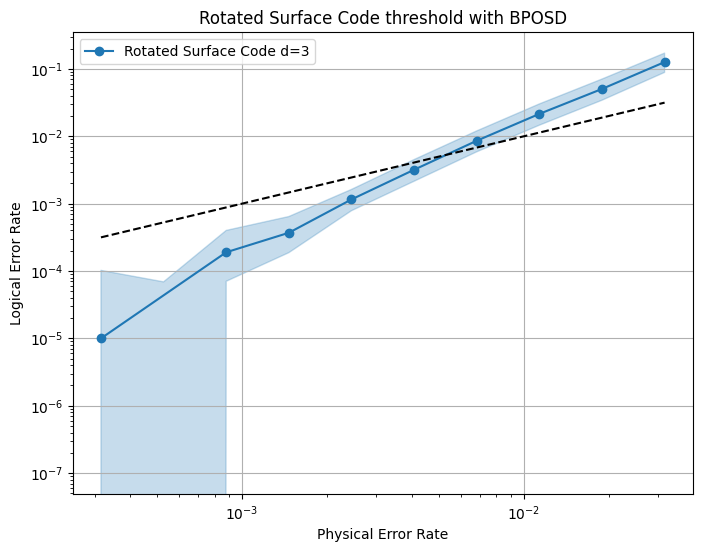

In [213]:
plot_results(samples)

# Code Archive

In [ ]:
def stim_steane_code(error_rate):
# steane code metadata
    steane_code = qldpc.codes.SteaneCode()
    code = steane_code
    repetitions = 10
    stabilizers = []
    
    circuit = cirq.Circuit()
    ancillas = []
    stab_circuit = cirq.Circuit()
    for anc_idx, check in enumerate(code.matrix_x):
        anc = cirq.NamedQubit(f"a{anc_idx}")
        # anc = cirq.LineQubit(7 + anc_idx)
        ancillas.append(anc)
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(check):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
                stabilizers.append(cirq.CX(anc, cirq.LineQubit(bit_idx)))
        stab_circuit += cirq.H(anc)
        
    # circuit += css.barrier(*circuit.all_qubits())
    
    for anc_idx, check in enumerate(code.matrix_z):
        anc = cirq.NamedQubit(f"a{anc_idx + 3}")
        # anc = cirq.LineQubit(7 + 3 + anc_idx)
        ancillas.append(anc)
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(check):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CZ(anc, cirq.LineQubit(bit_idx))
                stabilizers.append(cirq.CZ(anc, cirq.LineQubit(bit_idx)))
        stab_circuit += cirq.H(anc)
    data = sorted([q for q in stab_circuit.all_qubits() if isinstance(q, cirq.LineQubit)])
    qubits = list(stab_circuit.all_qubits())
    
    circuit = cirq.Circuit()
    for q in qubits:
        # circuit += cirq.R(q)
        circuit += stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q)
    stab_circuit = cirq.Circuit()
    stab_circuit += cirq.Moment([cirq.depolarize(error_rate).on(d) for d in data] + cirq.H.on_each(ancillas))
    stab_circuit += cirq.Circuit(cirq.Moment(stab) for stab in stabilizers)
    stab_circuit += cirq.Moment(cirq.H.on_each(ancillas))
    circuit += stab_circuit
    circuit += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    circuit += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))
    circuit += cirq.Moment(
        stimcirq.DetAnnotation(relative_keys=[-6], coordinate_metadata=(7.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-5], coordinate_metadata=(8.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-4], coordinate_metadata=(9.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-3], coordinate_metadata=(10.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-2], coordinate_metadata=(11.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-1], coordinate_metadata=(12.0, 0.0))
    )
    
    circuit_op = stab_circuit
    circuit_op += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))

    moment += cirq.Moment([stimcirq.ShiftCoordsAnnotation((0, 1))])
    moment += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[-len(ancillas) + idx, idx], coordinate_metadata=(len(qubits) + idx, 0)) for idx in range(-len(ancillas), 0)])

    # moment += cirq.Moment(
    #     stimcirq.ShiftCoordsAnnotation((0.0, 1.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-12, -6], coordinate_metadata=(7.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-11, -5], coordinate_metadata=(8.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-10, -4], coordinate_metadata=(9.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-9, -3], coordinate_metadata=(10.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-8, -2], coordinate_metadata=(11.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-7, -1], coordinate_metadata=(12.0, 0.0))
    # )
    
    circuit_op += moment
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))
    
    for idx, d in enumerate(data):
        circuit += cirq.X.with_probability(error_rate).on(d)
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis='X', invert_measure=False, key=idx).on(d)
    
    
    circuit += cirq.Moment(
        stimcirq.ShiftCoordsAnnotation((0.0, 1.0)),
        stimcirq.DetAnnotation(relative_keys=[-13, -1, -2, -3, -4], coordinate_metadata=(7.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-12, -1, -2, -5, -6], coordinate_metadata=(8.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-11, -1, -3, -5, -7], coordinate_metadata=(9.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-10, -1, -2, -3, -4], coordinate_metadata=(10.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-9, -1, -2, -5, -6], coordinate_metadata=(11.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-8, -1, -3, -5, -7], coordinate_metadata=(12.0, 0.0))
    )
    circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(relative_keys=[-1, -2, -3], observable_index=0))
    
    # return circuit.with_noise(cirq.depolarize(noise))
    return circuit